In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import setdataset as sds
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# For reproducibility
torch.manual_seed(314)
np.random.seed(314)

In [20]:
path = "/home/aldw/Repositories/set-solver-card-classifier/images"

mean = [0.6, 0.6, 0.6]
std = [0.2, 0.2, 0.2]

train_transforms = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.4),
                                       transforms.RandomRotation(25),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.ToTensor()]) 

# train_valid_data = sds.SetDataSet(path, train=True, transform=train_transforms)
# test_data = sds.SetDataSet(path, train=False, transform=test_transforms)
train_valid_data = datasets.ImageFolder(root=f"{path}/train",transform=train_transforms)
test_data = datasets.ImageFolder(root=f"{path}/test",transform=test_transforms)

train_size = int(np.floor(0.8 * len(train_valid_data)))
valid_size = len(train_valid_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_valid_data, [train_size, valid_size])
    
# Create dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [21]:
def show(img_loader, n_images):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(n_images):
        image = images[i] / 2 + 0.5
        image = image.numpy()
        print(labels[i])
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.show()

tensor(33)


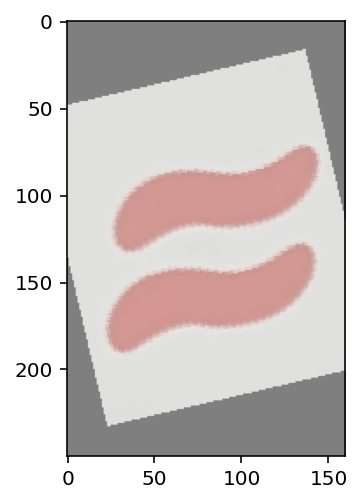

tensor(65)


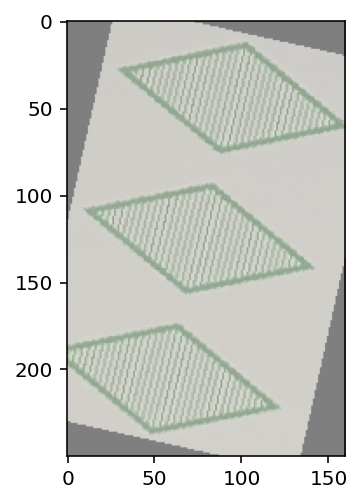

tensor(78)


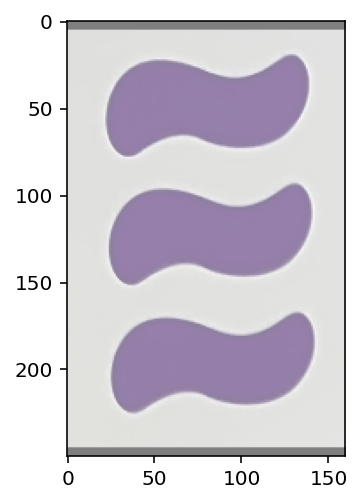

tensor(49)


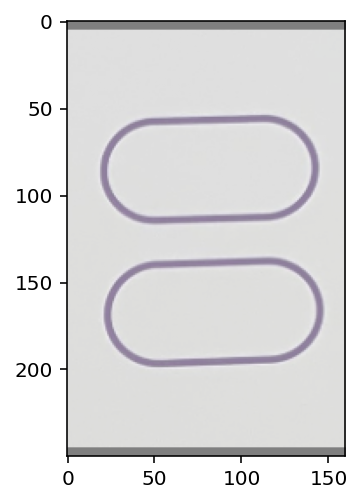

In [22]:
show(trainloader, 2)
show(testloader, 2)

https://towardsdatascience.com/detecting-set-cards-using-transfer-learning-b297dcf3a564

In [16]:
class SetCardClassifier(nn.Module):
    def __init__(self):
        super(SetCardClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(3*6*256, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 81)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # start: 160x250x3, after: 80x125x16
        x = self.pool(F.relu(self.conv2(x))) # after: 40x62x32
        x = self.pool(F.relu(self.conv3(x))) # after: 20x31x64
        x = self.pool(F.relu(self.conv4(x))) # after: 9x14x128
        x = self.pool(F.relu(self.conv5(x))) # after: 3x6x256
        x = x.view(-1, 3*6*256) # flatten image input
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [17]:
model = SetCardClassifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
print(f'training on device {device}')

epochs = 300
min_valid_loss = np.Inf # track change in validation loss
train_log = {
    "train_losses" : list(),
    "valid_losses" : list(),
    "valid_accuracy" : list()
}
for epoch in range(epochs):
    #######################
    # Training            #
    #######################
    train_loss = 0
    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    #######################
    # Validation          #
    #######################
    valid_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            valid_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            print(torch.unique(top_class))
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()

    #######################
    # Logging             #
    #######################
    avg_train_loss = train_loss/len(trainloader)
    avg_valid_loss = valid_loss/len(validloader)
    avg_valid_acc = accuracy/len(validloader)
    train_log["train_losses"].append(avg_train_loss)
    train_log["valid_losses"].append(avg_valid_loss)
    train_log["valid_accuracy"].append(avg_valid_acc)
    print(f"Epoch {epoch+1:03d}/{epochs:03d}.. "
          f"Train loss: {avg_train_loss:.3f}.. "
          f"Valid loss: {avg_valid_loss:.3f}.. "
          f"Valid accuracy: {avg_valid_acc:.3f}")
        
    #######################
    # Saving best model   #
    #######################
    if avg_valid_loss < min_valid_loss:
        print(f"found a better model, saving...")
        torch.save(model.state_dict(), 'model.pt')
        min_valid_loss = avg_valid_loss
    

training on device cuda
tensor([7], device='cuda:0')
Epoch 001/300.. Train loss: 4.405.. Valid loss: 4.416.. Valid accuracy: 0.000
found a better model, saving...
tensor([7], device='cuda:0')
Epoch 002/300.. Train loss: 4.395.. Valid loss: 4.426.. Valid accuracy: 0.000
tensor([54], device='cuda:0')
Epoch 003/300.. Train loss: 4.395.. Valid loss: 4.430.. Valid accuracy: 0.000
tensor([54], device='cuda:0')
Epoch 004/300.. Train loss: 4.392.. Valid loss: 4.440.. Valid accuracy: 0.000
tensor([26], device='cuda:0')
Epoch 005/300.. Train loss: 4.393.. Valid loss: 4.577.. Valid accuracy: 0.000
tensor([54], device='cuda:0')
Epoch 006/300.. Train loss: 4.396.. Valid loss: 4.455.. Valid accuracy: 0.000
tensor([7], device='cuda:0')
Epoch 007/300.. Train loss: 4.389.. Valid loss: 4.465.. Valid accuracy: 0.000
tensor([7], device='cuda:0')
Epoch 008/300.. Train loss: 4.387.. Valid loss: 4.475.. Valid accuracy: 0.000
tensor([7], device='cuda:0')
Epoch 009/300.. Train loss: 4.386.. Valid loss: 4.488..

KeyboardInterrupt: 